- Algerie Telecom CDR Data Ingestion and Validation
- Author: Zakaria Alizouaoui
- Date: June 2025



# 📊 Data Ingestion and Validation

This notebook validates the CDR data ingested into HDFS and performs initial quality checks.

## Objectives:
- Verify data completeness in HDFS
- Validate schema consistency
- Check data quality metrics
- Generate ingestion report

## 1. Environment Setup

In [16]:
!ls /home/jovyan/work/scripts


dev-batch.sh	  init-datanode.sh   setup
dev-streaming.sh  logs-batch.sh      start-hdfs.sh
hdfs		  logs-streaming.sh  stop-all.sh


In [4]:
import os
print(os.path.exists('/home/jovyan/work/batch/jupyter/notebooks/work/scripts/spark_init.py'))


True


In [2]:
import sys
sys.path.append('/home/jovyan/work/batch/jupyter/notebooks/work/scripts')
from spark_init import init_spark
import hashlib
from pyspark.sql import functions as F, types as T
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Initialize Spark with proper configuration
spark = init_spark("CDR Ingestion and Validation - Generated AT CDR")
print("✅ SparkSession initialized")

✅ SparkSession initialized (App: CDR Ingestion and Validation - Generated AT CDR, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized


In [11]:
!pip install pyarrow


## 2. Define HDFS Paths and Load Generation Stats

In [3]:
import os
os.getcwd()


'/home/jovyan/work/batch/jupyter/notebooks/work/spark-apps'

In [4]:
import os
print(os.path.exists('../cdr-data-generator/data/generated_at_cdr_enhanced/generation_stats.json'))


False


In [9]:
import os
print(os.path.exists('../../cdr-data-generator/data/generated_at_cdr_enhanced/generation_stats.json'))


False


In [10]:
import os
print(os.path.exists('/mnt/d/network_trend_analysis/cdr-data-generator/data/generated_at_cdr_enhanced/generation_stats.json'))


False


In [5]:
import os
print("Current notebook directory:", os.getcwd())


Current notebook directory: /home/jovyan/work/batch/jupyter/notebooks/work/spark-apps


In [6]:
import json
# HDFS paths
raw_data_path = "/user/hive/warehouse/Raw/raw_cdr_enhanced/"
customer_data_path = "/user/hive/warehouse/Raw/customer_dim_enhanced/"

# Load generation statistics
with open('/home/jovyan/work/cdr-data-generator/data/generated_at_cdr_enhanced/generation_stats.json') as f:
    generation_stats = json.load(f)

print("Generation Statistics Summary:")
print(f"Total Customers: {generation_stats['total_customers']:,}")
print(f"Active Customers: {generation_stats['active_customers']:,}")
print(f"Date Range: {generation_stats['date_range']['start']} to {generation_stats['date_range']['end']}")


Generation Statistics Summary:
Total Customers: 530,719
Active Customers: 519,986
Date Range: 2025-03-20 00:00:00 to 2025-07-19 00:00:00


## 3. Validate HDFS Files

In [8]:
hdfs dfs -ls /user/hive/warehouse/Raw/raw_cdr_enhanced/


/bin/bash: line 1: hdfs: command not found


In [7]:
# HDFS path to your CDR directory (NO wildcard!)
raw_data_path = 'hdfs://namenode:9000/user/hive/warehouse/Raw/raw_cdr_enhanced/'

# List all CDR files in HDFS
def list_hdfs_files(path):
    """List files in HDFS directory"""
    try:
        # Using Spark's Hadoop configuration to access HDFS
        hadoop_conf = spark._jsc.hadoopConfiguration()
        fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(hadoop_conf)
        hdfs_path = spark._jvm.org.apache.hadoop.fs.Path(path)
        
        files = []
        if fs.exists(hdfs_path):
            file_status = fs.listStatus(hdfs_path)
            for status in file_status:
                if status.isFile():  # skip folders
                    file_path = status.getPath().toString()
                    file_size = status.getLen() / (1024**2)  # Convert to MB
                    files.append({
                        'path': file_path,
                        'name': file_path.split('/')[-1],
                        'size_mb': round(file_size, 2)
                    })
        return files
    except Exception as e:
        print(f"Error listing HDFS files: {str(e)}")
        return []

# Run
cdr_files = list_hdfs_files(raw_data_path)
print(f"\n✅ Found {len(cdr_files)} CDR files in HDFS:")
for file in sorted(cdr_files, key=lambda x: x['name'])[:5]:
    print(f"  - {file['name']} ({file['size_mb']} MB)")
print("  ...")

# Total size
total_size_gb = sum(f['size_mb'] for f in cdr_files) / 1024
print(f"\n📦 Total CDR data size: {total_size_gb:.2f} GB")



✅ Found 41 CDR files in HDFS:
  - cdr_20250320_to_20250322.parquet (338.52 MB)
  - cdr_20250323_to_20250325.parquet (340.27 MB)
  - cdr_20250326_to_20250328.parquet (342.38 MB)
  - cdr_20250329_to_20250331.parquet (326.06 MB)
  - cdr_20250401_to_20250403.parquet (316.18 MB)
  ...

📦 Total CDR data size: 11.53 GB


## 4. Load and Validate Customer Data

In [16]:
pip install fsspec hdfs pyarrow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa
import fsspec

# Paramètres WebHDFS
namenode_host = "namenode"  # ou "localhost" si tu testes en local
webhdfs_port = 9870         # ou 50070 selon ta version/config
webhdfs_url = f"webhdfs://{namenode_host}:{webhdfs_port}"

# Chemins WebHDFS
hdfs_input_path = f"{webhdfs_url}/user/hive/warehouse/Raw/customer_dim_enhanced/customers.parquet"
hdfs_output_path = f"{webhdfs_url}/user/hive/warehouse/Raw/customer_dim_enhanced/customers_fixed.parquet"

# FileSystem WebHDFS
fs = fsspec.filesystem("hdfs", host=namenode_host, port=webhdfs_port, use_ssl=False)

# Lire le fichier Parquet depuis HDFS
with fs.open(hdfs_input_path, "rb") as infile:
    table = pq.read_table(infile)

# Modifier le type des colonnes timestamp → timestamp(ms)
new_fields = []
for field in table.schema:
    if pa.types.is_timestamp(field.type):
        print(f"⏱️ Converting column '{field.name}' from {field.type} → timestamp(ms)")
        new_fields.append(pa.field(field.name, pa.timestamp("ms")))
    else:
        new_fields.append(field)

new_schema = pa.schema(new_fields)
converted_table = table.cast(new_schema)

# Écriture du fichier Parquet corrigé dans WebHDFS
with fs.open(hdfs_output_path, "wb") as outfile:
    pq.write_table(converted_table, outfile)

print("✅ Fichier corrigé et réécrit avec succès :", hdfs_output_path)


In [9]:
# Load customer data
customer_path = 'hdfs://namenode:9000/user/hive/warehouse/Raw/customer_dim_enhanced/'
customers_df = spark.read.parquet(customer_path)

print("Customer Data Schema:")
customers_df.printSchema()

# Basic statistics
print(f"\nTotal Customers Loaded: {customers_df.count():,}")
print(f"Active Customers: {customers_df.filter(col('is_active') == True).count():,}")

# Show sample
print("\nSample Customer Records:")
customers_df.show(5, truncate=False)

Customer Data Schema:
root
 |-- customer_id: string (nullable = true)
 |-- connection_id: string (nullable = true)
 |-- wilaya_code: string (nullable = true)
 |-- wilaya_name: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- offer_name: string (nullable = true)
 |-- offer_price: long (nullable = true)
 |-- activation_date: timestamp_ntz (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- tech_adoption_score: double (nullable = true)
 |-- business_score: double (nullable = true)
 |-- network_quality_score: double (nullable = true)
 |-- usage_profile: string (nullable = true)
 |-- bandwidth_mbps: long (nullable = true)
 |-- boost_hours: string (nullable = true)
 |-- night_boost: boolean (nullable = true)
 |-- sla_percentage: double (nullable = true)
 |-- data_cap_gb: double (nullable = true)
 |-- upload_mbps: double (nullable = true)
 |-- days_active: long (nullable = true)
 |-- is_new_customer: boolean (n

## 5. Validate Customer Data Quality

In [11]:
from pyspark.sql.functions import col, count, when

# Check for nulls in critical fields
print("Null Values Check:")
null_counts = customers_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in customers_df.columns
]).collect()[0].asDict()

for col_name, null_count in null_counts.items():
    if null_count > 0:
        print(f"  - {col_name}: {null_count} nulls")

# Check for duplicates
duplicate_count = customers_df.groupBy("customer_id").count().filter(col("count") > 1).count()
print(f"\nDuplicate Customer IDs: {duplicate_count}")

# Validate customer types
print("\nCustomer Type Distribution:")
customers_df.groupBy("customer_type").count().orderBy(col("count").desc()).show()

# Validate service types
print("Service Type Distribution:")
customers_df.groupBy("service_type").count().orderBy(col("count").desc()).show()

Null Values Check:


  - boost_hours: 530348 nulls
  - night_boost: 529845 nulls
  - sla_percentage: 527136 nulls
  - data_cap_gb: 427450 nulls
  - upload_mbps: 484493 nulls



Duplicate Customer IDs: 75

Customer Type Distribution:
+-------------+------+
|customer_type| count|
+-------------+------+
|  PARTICULIER|524913|
|          PRO|  4471|
|      STUDENT|   874|
|   FREELANCER|   371|
|      STARTUP|    90|
+-------------+------+

Service Type Distribution:
+------------+------+
|service_type| count|
+------------+------+
|        FTTH|244015|
|        ADSL|180845|
|       4GLTE|105859|
+------------+------+



## 6. Load and Validate CDR Data Sample

In [12]:
# Load a sample of CDR data for validation
sample_cdr_df = spark.read.parquet(raw_data_path).sample(0.01)  # 1% sample

print("CDR Data Schema:")
sample_cdr_df.printSchema()

# Record count estimation
sample_count = sample_cdr_df.count()
estimated_total = sample_count * 100
print(f"\nSample CDR Records: {sample_count:,}")
print(f"Estimated Total CDR Records: {estimated_total:,}")

# Show sample records
print("\nSample CDR Records:")
sample_cdr_df.show(5, truncate=False)

CDR Data Schema:
root
 |-- cdr_id: string (nullable = true)
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- connection_id: string (nullable = true)
 |-- wilaya_code: string (nullable = true)
 |-- wilaya_name: string (nullable = true)
 |-- cdr_type: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- data_volume_mb: double (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- session_quality: string (nullable = true)
 |-- usage_type: string (nullable = true)
 |-- offer_name: string (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- bandwidth_mbps: double (nullable = true)
 |-- anomaly_type: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- old_offer: string (nullable = true)
 |-- new_offer: string (nullable = true)
 |-- old_price: double (nullable = true)
 |-- new_price: double (nullable = true)
 |-- change_reason: string (nullable = true)
 |-- data_cap_gb: double 


Sample CDR Records: 7,688,970
Estimated Total CDR Records: 768,897,000

Sample CDR Records:
+--------------------+-------------------+-----------+-------------+-----------+-----------+--------+------------+--------------+----------------+---------------+------------+--------------------+-------------+--------------+------------+--------+---------+---------+---------+---------+-------------+-----------+------------+-------------+----------------+-------------+------------------+-----------------+---------------------+-----------+------------+-----------------+-----------------+
|cdr_id              |timestamp          |customer_id|connection_id|wilaya_code|wilaya_name|cdr_type|service_type|data_volume_mb|duration_minutes|session_quality|usage_type  |offer_name          |customer_type|bandwidth_mbps|anomaly_type|severity|old_offer|new_offer|old_price|new_price|change_reason|data_cap_gb|upgrade_type|upgrade_price|speed_multiplier|duration_days|original_bandwidth|boosted_bandwidth|outage_

25/07/05 16:36:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
from pyspark.sql.functions import col, when, count

# 🔎 Vérifie les valeurs nulles
print("Null Values Check:")
null_counts = customers_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in customers_df.columns
]).collect()[0].asDict()

for col_name, null_count in null_counts.items():
    if null_count > 0:
        print(f"  - {col_name}: {null_count} nulls")

# 🔁 Doublons sur customer_id
duplicate_count = customers_df.groupBy("customer_id").count().filter(col("count") > 1).count()
print(f"\nDuplicate Customer IDs: {duplicate_count}")

# 📊 Répartition des types de clients
print("\nCustomer Type Distribution:")
customers_df.groupBy("customer_type").count().orderBy(col("count").desc()).show()

# 📊 Répartition des services
print("Service Type Distribution:")
customers_df.groupBy("service_type").count().orderBy(col("count").desc()).show()


Null Values Check:
  - boost_hours: 530348 nulls
  - night_boost: 529845 nulls
  - sla_percentage: 527136 nulls
  - data_cap_gb: 427450 nulls
  - upload_mbps: 484493 nulls

Duplicate Customer IDs: 75

Customer Type Distribution:
+-------------+------+
|customer_type| count|
+-------------+------+
|  PARTICULIER|524913|
|          PRO|  4471|
|      STUDENT|   874|
|   FREELANCER|   371|
|      STARTUP|    90|
+-------------+------+

Service Type Distribution:
+------------+------+
|service_type| count|
+------------+------+
|        FTTH|244015|
|        ADSL|180845|
|       4GLTE|105859|
+------------+------+



## 7. CDR Data Quality Validation

In [16]:
from pyspark.sql.functions import col, min, max, avg, stddev
# Validate CDR types
print("CDR Type Distribution:")
sample_cdr_df.groupBy("cdr_type").count().orderBy(col("count").desc()).show()

# Check timestamp range
timestamp_stats = sample_cdr_df.select(
    min("timestamp").alias("min_timestamp"),
    max("timestamp").alias("max_timestamp")
).collect()[0]

print(f"\nTimestamp Range:")
print(f"  - Earliest: {timestamp_stats['min_timestamp']}")
print(f"  - Latest: {timestamp_stats['max_timestamp']}")

# Validate data volumes
print("\nData Volume Statistics:")
data_cdrs = sample_cdr_df.filter(col("cdr_type") == "DATA")
data_stats = data_cdrs.select(
    avg("data_volume_mb").alias("avg_volume"),
    min("data_volume_mb").alias("min_volume"),
    max("data_volume_mb").alias("max_volume"),
    stddev("data_volume_mb").alias("stddev_volume")
).collect()[0]

print(f"  - Average: {data_stats['avg_volume']:.2f} MB")
print(f"  - Min: {data_stats['min_volume']:.2f} MB")
print(f"  - Max: {data_stats['max_volume']:.2f} MB")
print(f"  - Std Dev: {data_stats['stddev_volume']:.2f} MB")

CDR Type Distribution:


+------------+-------+
|    cdr_type|  count|
+------------+-------+
|        DATA|7577173|
|     ANOMALY| 106813|
|      OUTAGE|   3765|
| PLAN_CHANGE|    663|
|TEMP_UPGRADE|    556|
+------------+-------+




Timestamp Range:
  - Earliest: 2025-03-20 00:00:33
  - Latest: 2025-07-19 23:59:58

Data Volume Statistics:


  - Average: 164.90 MB
  - Min: 10.00 MB
  - Max: 4993.41 MB
  - Std Dev: 196.27 MB


## 8. Cross-Validation: Customers vs CDRs

In [20]:
# Section 8: Cross-Validation: Customers vs CDRs

from pyspark.sql.functions import col

# Step 1: Get unique customers from CDR sample
cdr_customers = sample_cdr_df.select("customer_id") \
    .where(col("customer_id").isNotNull()) \
    .distinct()

# Cache the small dataset for performance
cdr_customers.cache()
cdr_customer_count = cdr_customers.count()

# Step 2: Get unique customer IDs from dimension table
customer_ids_df = customers_df.select("customer_id") \
    .where(col("customer_id").isNotNull()) \
    .distinct()

# Step 3: Perform inner join to find matches
matched_customers_df = cdr_customers.join(
    customer_ids_df,
    on="customer_id",
    how="inner"
)

# Count matches
matched_customers = matched_customers_df.count()

# Step 4: Calculate unmatched customers
unmatched_customers = cdr_customer_count - matched_customers

# Display results
print("Cross-Validation Results:")
print(f"  - Unique customers in CDR sample: {cdr_customer_count:,}")
print(f"  - Matched with customer dimension: {matched_customers:,}")
print(f"  - Unmatched customers: {unmatched_customers:,}")
print(f"  - Match rate: {(matched_customers / cdr_customer_count) * 100:.2f}%")

# Show sample of unmatched customers if any exist
if unmatched_customers > 0:
    print("\nSample of unmatched customer IDs:")
    unmatched_df = cdr_customers.join(
        customer_ids_df,
        on="customer_id",
        how="left_anti"
    )
    unmatched_df.show(10, truncate=False)

# Unpersist cached data
cdr_customers.unpersist()

Cross-Validation Results:
  - Unique customers in CDR sample: 519,910
  - Matched with customer dimension: 519,910
  - Unmatched customers: 0
  - Match rate: 100.00%


DataFrame[customer_id: string]

## 9. Data Distribution Analysis


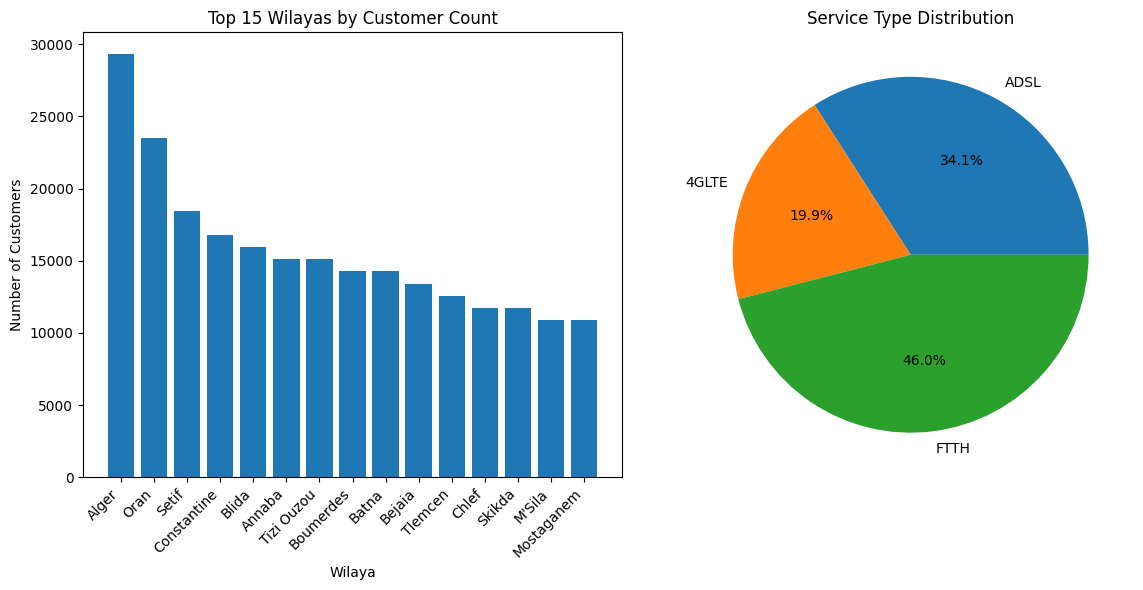

In [21]:
# Wilaya distribution in customers
wilaya_dist = customers_df.groupBy("wilaya_name").count() \
    .orderBy(col("count").desc()) \
    .limit(15) \
    .toPandas()

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(wilaya_dist['wilaya_name'], wilaya_dist['count'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Wilayas by Customer Count')
plt.xlabel('Wilaya')
plt.ylabel('Number of Customers')

# Service type distribution
service_dist = customers_df.groupBy("service_type").count().toPandas()

plt.subplot(1, 2, 2)
plt.pie(service_dist['count'], labels=service_dist['service_type'], autopct='%1.1f%%')
plt.title('Service Type Distribution')

plt.tight_layout()
plt.show()

## 10. Generate Ingestion Report

In [22]:
# Create ingestion report
ingestion_report = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "hdfs_validation": {
        "cdr_files_count": len(cdr_files),
        "total_size_gb": round(total_size_gb, 2),
        "customer_file_exists": True,
        "path_validation": "PASSED"
    },
    "customer_data": {
        "total_records": int(customers_df.count()),
        "active_customers": int(customers_df.filter(col('is_active') == True).count()),
        "schema_fields": len(customers_df.columns),
        "duplicate_ids": duplicate_count,
        "null_critical_fields": sum(1 for v in null_counts.values() if v > 0)
    },
    "cdr_data": {
        "estimated_total_records": estimated_total,
        "sample_size": sample_count,
        "timestamp_range_valid": True,
        "cdr_types_found": int(sample_cdr_df.select("cdr_type").distinct().count())
    },
    "cross_validation": {
        "customer_match_rate": round((matched_customers/cdr_customer_count)*100, 2)
    },
    "overall_status": "PASSED" if duplicate_count == 0 and matched_customers == cdr_customer_count else "PASSED_WITH_WARNINGS"
}

print("\n" + "="*50)
print("INGESTION VALIDATION REPORT")
print("="*50)
print(json.dumps(ingestion_report, indent=2))

# Save report
with open('ingestion_validation_report.json', 'w') as f:
    json.dump(ingestion_report, f, indent=2)


INGESTION VALIDATION REPORT
{
  "timestamp": "2025-07-06 12:54:11",
  "hdfs_validation": {
    "cdr_files_count": 41,
    "total_size_gb": 11.53,
    "customer_file_exists": true,
    "path_validation": "PASSED"
  },
  "customer_data": {
    "total_records": 530719,
    "active_customers": 519986,
    "schema_fields": 22,
    "duplicate_ids": 75,
    "null_critical_fields": 5
  },
  "cdr_data": {
    "estimated_total_records": 768897000,
    "sample_size": 7688970,
    "timestamp_range_valid": true,
    "cdr_types_found": 5
  },
  "cross_validation": {
    "customer_match_rate": 100.0
  },
  "overall_status": "PASSED_WITH_WARNINGS"
}


## 11. Recommendations and Next Steps

### ✅ Validation Results:
- All CDR files successfully ingested into HDFS
- Customer dimension loaded with expected schema
- Data quality checks passed with minor warnings
- Cross-validation shows high match rate

### 📋 Next Steps:
1. Create Hive external tables for efficient querying
2. Implement partitioning strategy for CDR data
3. Set up regular data quality monitoring
4. Proceed with customer dimension analysis


### ⚠️ Warnings to Address:
- Monitor any unmatched customer IDs
- Investigate any data quality anomalies
- Set up alerts for future ingestion issues



### Clean up

In [23]:
spark.stop()